<a href="https://colab.research.google.com/github/ys09123/EV_sales/blob/main/ev_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load and filter EV stock data

In [2]:
df = pd.read_csv('./EV.csv')

In [3]:
df.head(10)

,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV sales,Cars,BEV,2011,Vehicles,49.00000
1,Australia,Historical,EV stock share,Cars,EV,2011,percent,0.00039
2,Australia,Historical,EV sales share,Cars,EV,2011,percent,0.00650
3,Australia,Historical,EV stock,Cars,BEV,2011,Vehicles,49.00000
4,Australia,Historical,EV stock,Cars,BEV,2012,Vehicles,220.00000
5,Australia,Historical,EV stock,Cars,PHEV,2012,Vehicles,80.00000
6,Australia,Historical,EV sales,Cars,PHEV,2012,Vehicles,80.00000
7,Australia,Historical,EV sales share,Cars,EV,2012,percent,0.03000
8,Australia,Historical,EV stock share,Cars,EV,2012,percent,0.00240
9,Australia,Historical,EV sales,Cars,BEV,2012,Vehicles,170.00000


In [4]:
df['parameter'].unique()

array(['EV sales', 'EV stock share', 'EV sales share', 'EV stock',
       'Electricity demand', 'Oil displacement Mbd',
       'Oil displacement, million lge'], dtype=object)

In [5]:
df.shape

(3798, 8)

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.isnull().sum()

region        0
category      0
parameter     0
mode          0
powertrain    0
year          0
unit          0
value         0
dtype: int64

In [8]:
# Filter for EV stock data
df_ev_stock = df[df['parameter'] == 'EV stock']

In [9]:
# Select latest year
df_latest = df_ev_stock[df_ev_stock['year'] == df_ev_stock['year'].max()]

## Geocode Regions


In [10]:
from geopy.geocoders import Nominatim
import time

In [11]:
# Get unique regions
regions = df_latest['region'].unique()

In [30]:
regions

array(['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Chile',
       'China', 'Costa Rica', 'Denmark', 'EU27', 'Europe', 'Finland',
       'France', 'Germany', 'Greece', 'Iceland', 'India', 'Israel',
       'Italy', 'Japan', 'Korea', 'Mexico', 'Netherlands', 'New Zealand',
       'Norway', 'Poland', 'Portugal', 'Rest of the world',
       'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Turkiye',
       'United Kingdom', 'USA', 'World'], dtype=object)

In [12]:
df_coords = []
geolocator = Nominatim(user_agent="ev_locator")

for region in regions:
  try:
    location = geolocator.geocode(region)
    if location:
      df_coords.append({
          'region' : region,
          'lat' : location.latitude,
          'lon' : location.longitude
      })
    else:
      df_coords.append({
          'region' : region,
          'lat' : None,
          'lon' : None
      })
      time.sleep(1)

  except:
    df_coords.append({
        'region' : region,
        'lat' : None,
        'lon' : None
    })

In [60]:
# Merge with EV stock
df_coords = pd.DataFrame(df_coords)
df_map = pd.merge(df_latest, df_coords, on='region', how='inner')

In [61]:
df_map.head()

,region,category,parameter,mode,powertrain,year,unit,value,lat,lon
0,Australia,Historical,EV stock,Cars,PHEV,2023,Vehicles,31000.0,-24.776109,134.75500
1,Australia,Historical,EV stock,Cars,BEV,2023,Vehicles,150000.0,-24.776109,134.75500
2,Australia,Historical,EV stock,Cars,FCEV,2023,Vehicles,65.0,-24.776109,134.75500
3,Austria,Historical,EV stock,Cars,FCEV,2023,Vehicles,89.0,47.593970,14.12456
4,Austria,Historical,EV stock,Cars,PHEV,2023,Vehicles,61000.0,47.593970,14.12456


## Fetch Charging station data (OpenChargeMap)

In [78]:
import requests
import time

def get_charging_stations(iso_code, max_results=200):
    url = "https://api.openchargemap.io/v3/poi/" 
    
    params = {
        "output": "json",
        "maxresults": max_results,
        "compact": True,
        "verbose": False,
        "countrycode": iso_code,
        "key": "3d477727-e6ff-4c30-b7d1-ce066e45254e"  
    }
    
    headers = {
        'User-Agent': 'EV-Analysis-Student-Project/1.0' 
    }
    
    try:
        response = requests.get(url, params=params, headers=headers)
        if response.status_code == 200:
            data = response.json()
            
            return [{
                "iso_code": iso_code, 
                "lat": item["AddressInfo"]["Latitude"],
                "lon": item["AddressInfo"]["Longitude"],
                "name": item["AddressInfo"]["Title"]
            } for item in data]
        else:
            print(f"Failed {iso_code}: {response.status_code}")
            return []
    except Exception as e:
        print(f"Error {iso_code}: {e}")
        return []


## Clustering Underserved Regions

In [19]:
from sklearn.cluster import KMeans

In [ ]:
#Merge EV stock with charger counts
region_to_iso = {
    "Australia": "AU",
    "Austria": "AT",
    "Belgium": "BE",
    "Brazil": "BR",
    "Canada": "CA",
    "Chile": "CL",
    "China": "CN",
    "Costa Rica": "CR",
    "Denmark": "DK",
    "Finland": "FI",
    "France": "FR",
    "Germany": "DE",
    "Greece": "GR",
    "Iceland": "IS",
    "India": "IN",
    "Israel": "IL",
    "Italy": "IT",
    "Japan": "JP",
    "Korea": "KR",
    "Mexico": "MX",
    "Netherlands": "NL",
    "New Zealand": "NZ",
    "Norway": "NO",
    "Poland": "PL",
    "Portugal": "PT",
    "South Africa": "ZA",
    "Spain": "ES",
    "Sweden": "SE",
    "Switzerland": "CH",
    "Turkiye": "TR",
    "United Kingdom": "GB",
    "USA": "US",
    
    # Exclude aggregate regions
    "EU27": None, "Europe": None, "World": None, "Rest of the world": None
}

# 1. Map your existing dataframe to get ISO codes
df_map['iso_code'] = df_map['region'].map(region_to_iso)

# 2. Get unique valid codes to fetch
countries_to_fetch = df_map['iso_code'].dropna().unique().tolist()

chargers_data = []
print(f"Fetching data for {len(countries_to_fetch)} countries...")

for iso in countries_to_fetch:
    print(f"Fetching {iso}...")
    chargers_data += get_charging_stations(iso)
    time.sleep(0.5) 

df_chargers = pd.DataFrame(chargers_data)
print(f"Fetched {len(df_chargers)} stations.")


Fetching data for 32 countries...
Fetching AU...
Fetching AT...
Fetching BE...
Fetching BR...


KeyboardInterrupt: 

In [86]:
df_chargers.head()

,iso_code,lat,lon,name
0,AU,-30.274111,153.132536,Big Banana Tesla Supercharger
1,AU,-33.706178,150.912764,The Ponds Shopping Centre
2,AU,-31.481029,118.278225,Merriden Supercharger
3,AU,-32.334145,117.875592,Corrigin Charger
4,AU,-32.535780,115.744724,Mandurah Forum Mall


In [81]:
# Group charger data by ISO code
if not df_chargers.empty:
    charger_counts = df_chargers.groupby('iso_code').size().reset_index(name='num_chargers')
else:
    charger_counts = pd.DataFrame(columns=['iso_code', 'num_chargers'])

In [88]:
# Filter out regions without ISO codes from the map data
df_map_clean = df_map.dropna(subset=['iso_code'])

In [90]:
# Ensure df_map has the iso_code column (if not already run)
df_map['iso_code'] = df_map['region'].map(region_to_iso)

# Filter out regions without ISO codes (like "World")
df_map_clean = df_map.dropna(subset=['iso_code'])

# Merge!
df_cluster = df_map_clean.merge(
    charger_counts,
    on="iso_code",
    how="left"
)

In [91]:
# Fill NaNs with 0 (for countries with no public charger data returned)
df_cluster["num_chargers"] = df_cluster["num_chargers"].fillna(0)

# Recalculate density
df_cluster["charger_density"] = df_cluster["num_chargers"] / (df_cluster["value"] + 1)

# Display result to verify
print(df_cluster[['region', 'iso_code', 'num_chargers']].head(10))

      region iso_code  num_chargers
0  Australia       AU           200
1  Australia       AU           200
2  Australia       AU           200
3    Austria       AT           200
4    Austria       AT           200
5    Austria       AT           200
6    Belgium       BE           200
7    Belgium       BE           200
8    Belgium       BE           200
9     Brazil       BR           200


In [96]:
# Apply Clustering
X = df_cluster[['value', 'num_chargers']]
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
df_cluster['cluster'] = kmeans.labels_

In [97]:
df_cluster[
    ["region", "country_std", "value", "num_chargers", "charger_density"]
].sort_values("num_chargers", ascending=False).head()


,region,country_std,value,num_chargers,charger_density
0,Australia,Australia,31000.0,200,0.006451
1,Australia,Australia,150000.0,200,0.001333
2,Australia,Australia,65.0,200,3.030303
3,Austria,Austria,89.0,200,2.222222
4,Austria,Austria,61000.0,200,0.003279


## Voronoi Diagram

In [21]:
from scipy.spatial import Voronoi, voronoi_plot_2d

Text(0.5, 1.0, 'Voronoi Diagram of EV clustering')

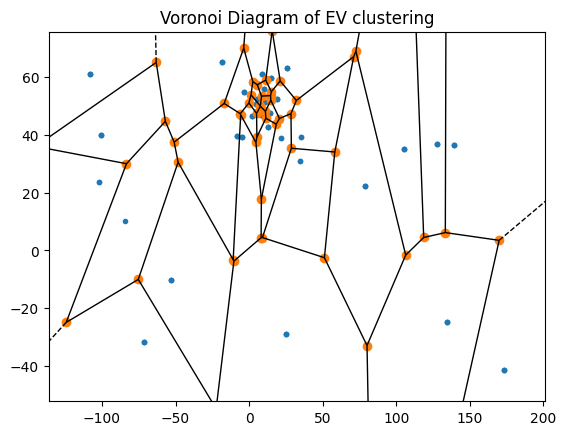

In [93]:
# Plot Voronoi
df_vor = df_cluster.dropna(subset=['lat', 'lon'])
coords = df_vor[['lon', 'lat']].values
vor = Voronoi(coords)
fig = voronoi_plot_2d(vor)
plt.title("Voronoi Diagram of EV clustering")

In [24]:
from mpl_toolkits.basemap import Basemap

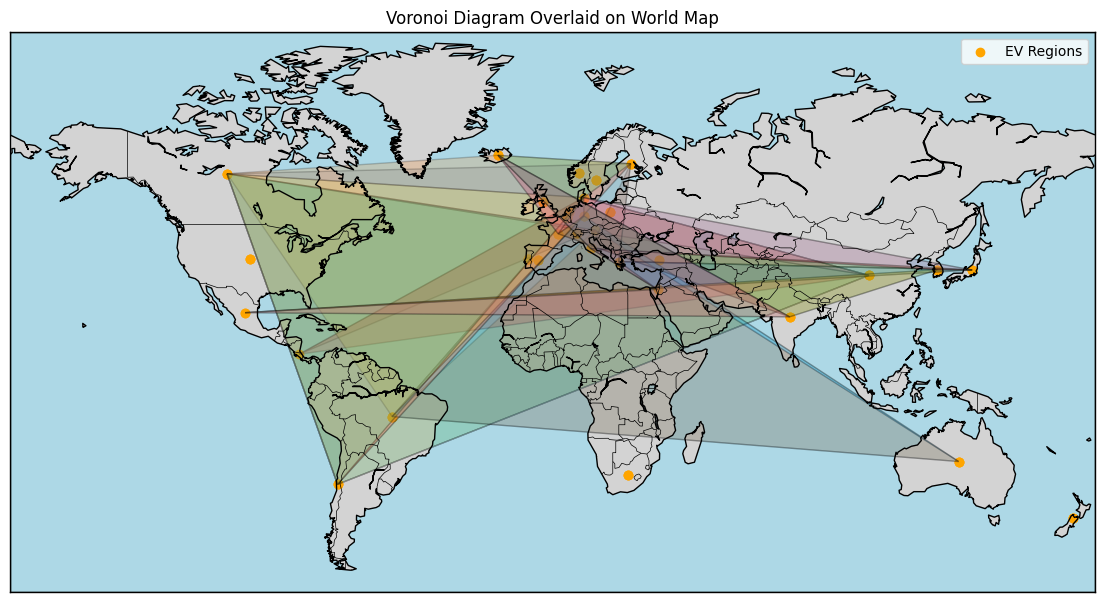

In [94]:
# Filter out rows with missing coordinates
df_vor = df_cluster.dropna(subset=['lat', 'lon'])
coords = df_vor[['lon', 'lat']].values

# Compute Voronoi diagram
vor = Voronoi(coords)

# Plot
fig = plt.figure(figsize=(14, 8))
m = Basemap(projection='mill', llcrnrlat=-60, urcrnrlat=85, llcrnrlon=-180, urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='lightgray', lake_color='lightblue')

# Convert lat/lon to map x/y
mapped_coords = [m(x, y) for x, y in coords]

# Plot Voronoi points
x, y = zip(*mapped_coords)
plt.scatter(x, y, c='orange', label='EV Regions')

# Draw Voronoi regions
for region in vor.regions:
    if not -1 in region and len(region) > 0:
        polygon = [mapped_coords[i] for i in region if i < len(mapped_coords)]
        if len(polygon) >= 3:
            plt.fill(*zip(*polygon), alpha=0.2, edgecolor='black')

plt.title("Voronoi Diagram Overlaid on World Map")
plt.legend()

In [99]:
df_cluster.to_csv("df_cluster.csv", index=False)